In [59]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # to print multiple outputs from the same cell
import math
import utils
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from operator import index
from collections import defaultdict
from scipy.stats import pearsonr
from datetime import datetime
#from lingua import Language, LanguageDetectorBuilder

In [60]:
users_df = pd.read_csv("dataset/users.csv")
tweets_df = pd.read_csv("dataset/tweets.csv")

# Data Understanding and Preparation

## Users Data

In users.csv there are the following variables:
1. User Id: a unique identifier of the user
2. Statues Count: According to the teacher, this is the count of the tweets made by the user at the moment of data
crawling. According to [Twitter API docs](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/user), this is the number of Tweets (including retweets) issued by the user, but not replies (according to Francesca Naretto); since tweets.csv inclues also users' replies note that **there is no link between the number of tweets for each user in tweets.csv and statuses_count**.
3. Lang: the user’s language selected
4. Created at: the timestamp in which the profile was created
5. Label: a binary variable that indicates if a user is a bot or a genuine user

In [61]:
users_df.info(verbose=True, show_counts=True, memory_usage= "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              11508 non-null  int64  
 1   name            11507 non-null  object 
 2   lang            11508 non-null  object 
 3   bot             11508 non-null  int64  
 4   created_at      11508 non-null  object 
 5   statuses_count  11109 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 2.5 MB


### Attribute type and quality

In the **user** dataset there are 6 columns:

1. The id **column** seems to be ok, all values are integer and there are not null values, we have to check possible duplicates
 
2. We have 1 null value in the **name** column, we also assume that the name could be a string, a number or a special character, the names are not necessarily unique, but maybe it's intresting to check the frequency distribution.

3. In the **lang** column we don't have null values, but we have to check whether there are problems in the pattern used to express the language, we expect a categorical attribute 

4. The **bot** column is numerical as expected (binary), we have to check whether all the numbers are 0 or 1

5. The attribute **created_at** has no null values, but we have to check the correctness of the date, both sintactic and semantic (not too far in the past or in the future)

6. The **status_count** column has 399 of null values, in the non-null values there would semm to be unexpected float

Let's verify the uniqueness of ids: all the ids are unique!

In [62]:
print("Number of total IDs:", len(users_df["id"]))
print("Number of unique IDs:", len(pd.unique(users_df["id"])))

Number of total IDs: 11508
Number of unique IDs: 11508


As said before one name is null. There are also duplicate names, but this isn't a surprising behaviour, as many people have the same names. By plotting the names' frequencies we can see that there aren't strange phenomena.

Number of total names: 11508
Number of unique names: 11361
Number of total names = 11508 vs total name values that are not NA or empty = 11507
Number of total names = 11508 vs total name values that are NA or empty = 1


array([[<AxesSubplot: title={'center': 'frequencies'}>]], dtype=object)

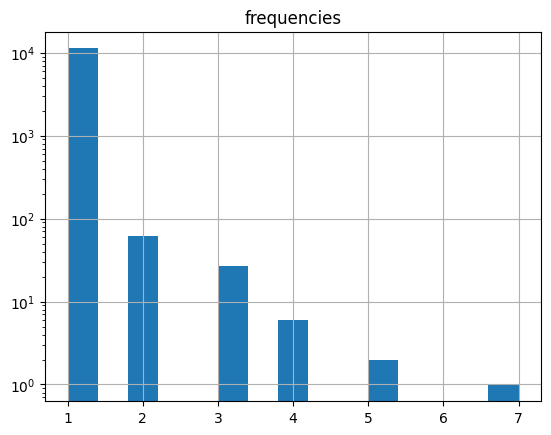

In [63]:
print("Number of total names:", len(users_df["name"]))
print("Number of unique names:", len(pd.unique(users_df["name"])))

freq = {}
for n in users_df['name']:
    if n in freq:
        freq[n] += 1
    else:
        freq[n] = 1

number_of_total_names = len(users_df["name"])
not_empty_or_missing_names = []
empty_or_missing_names = []
names_with_only_spaces = []

# iterate over all names looking for errors
for value in users_df["name"]:
    if pd.isna(value) or value == "": # name is nan or is_empty string
        empty_or_missing_names.append(value)
    if str(value).strip() == "":
            names_with_only_spaces.append(value)
    elif not(pd.isna(value) or value == ""):
        not_empty_or_missing_names.append(value)
        
print(f"Number of total names = {number_of_total_names} vs total name values that are not NA or empty = {len(not_empty_or_missing_names)}")
print(f"Number of total names = {number_of_total_names} vs total name values that are NA or empty = {len(empty_or_missing_names)}")

pd.DataFrame({"frequencies": [_ for _ in freq.values()]}).hist(
    column=["frequencies"], 
    log=True, 
    bins=utils.get_sturges_bins(len(freq.values()))
)

We don't see the 1 missing name to be of any significance. So we will just let it be for now. Now let's check the different languages in the "lang" column.

In [64]:
pd.unique(users_df["lang"])  

array(['en', 'it', 'fr', 'ru', 'es', 'tr', 'en-gb', 'pt', 'nl', 'id',
       'zh-tw', 'ja', 'de', 'ko', 'en-AU', 'da', 'ar', 'en-GB',
       'Select Language...', 'zh-TW', 'zh-cn', 'pl', 'el', 'fil', 'sv',
       'xx-lc'], dtype=object)

The "lang" field is composed of [IETF language codes](https://en.wikipedia.org/wiki/IETF_language_tag). By selecting only the unique values it's possible to see that there are some erroneous values:
* "Select Language..." and "xx-lc" seems to be **default values**
* other values are not properly correct (e.g. "zh-cn" instead of "zh-CN")
We propose to check the most common language used by these 'erroneous values' users and provide them with a more fitting language attribute. This will be done after we have analysed the tweets data.

In [65]:
utils.repair_lang_attribute(users_df)
pd.unique(users_df["lang"])

array(['en', 'it', 'fr', 'ru', 'es', 'tr', 'en-GB', 'pt', 'nl', 'id',
       'zh-TW', 'ja', 'de', 'ko', 'en-AU', 'da', 'ar',
       'Select Language...', 'zh-CN', 'pl', 'el', 'fil-PH', 'sv', 'xx-lc'],
      dtype=object)

Since wrong values are just the 0.02% of the number of rows they are just dropped *(!!! the actual code in utils.py doesn't drop the default values)*, while the other values are mapped to the correct ones.

The bot attribute is perfectly as expected, all non-null binary values

In [66]:
pd.unique(users_df["bot"])

array([1, 0])

We observe that the created_at coloumn is recognized by pandas as an object, and not as a datetime as we would expect from this attribute. Clean created_at field, by converting string to datetime. We can also note that there are no users whose account was created before (after) the date of creation of the first tweet.

In [67]:
# parsing string to datetime obj
users_df["created_at"] = pd.to_datetime(users_df["created_at"])

before_time_users_df = users_df[users_df["created_at"] < datetime(2006,3,21,9,50,0)]
before_time_users_df.info()

# finding tweets created after dataset release
before_time_users_df = users_df[users_df["created_at"] > datetime(2022,9,29,11,0,0)]
before_time_users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              0 non-null      int64         
 1   name            0 non-null      object        
 2   lang            0 non-null      object        
 3   bot             0 non-null      int64         
 4   created_at      0 non-null      datetime64[ns]
 5   statuses_count  0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 0.0+ bytes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              0 non-null      int64         
 1   name            0 non-null      object        
 2   lang            0 non-null      object        
 3   bot             0 non-null      int64         
 4  

We expect the statuses count to be an integer, but pandas has interpreted it as a float. This is probably due to the presence of NaN values. Checking for NaN values.

In [68]:
users_df[users_df["statuses_count"].isna()]

,id,name,lang,bot,created_at,statuses_count
8,616225564,Anisha Williams,en,0,2017-06-25 15:49:36,NaN
20,1370348599,Robert Brown,en,0,2018-04-23 19:05:48,NaN
66,617369459,Sage Pennington,en,0,2017-06-26 18:50:48,NaN
77,2362195375,Delaine Nock,en,0,2019-02-28 05:35:38,NaN
110,2351047069,Tosha Pacitti,en,0,2019-02-21 03:14:40,NaN
...,...,...,...,...,...,...
11256,2352903248,Margherita Dass,en,0,2019-02-22 07:59:20,NaN
11321,2366095543,Annmarie Willoby,en,0,2019-03-02 20:53:35,NaN
11332,1176282888,Blanch Mobley,en,0,2018-02-15 17:38:55,NaN
11391,1175005345,Marna Lemley,en,0,2018-02-15 11:27:01,NaN


In [69]:
nan_status_count_users_df = users_df[users_df["statuses_count"].isna()]
list_of_humans = []
list_of_bots = []
for elem in nan_status_count_users_df["bot"]:
    if elem == 1:
        list_of_bots.append(elem)
    elif elem == 0:
        list_of_humans.append(elem)
    else:
        print("Didnt work")

print(f"Users with NaN values for statuses_count, consists of {len(list_of_humans)} humans and {len(list_of_bots)} bots")

#nan_status_count_users_df.groupby("bot", dropna=False).get_group(0)

Users with NaN values for statuses_count, consists of 399 humans and 0 bots


In [70]:
Number_of_users_in_dataset_that_are_bots = users_df.groupby("bot").get_group(1)
Number_of_users_in_dataset_that_are_humans = users_df.groupby("bot").get_group(0)
total = len(Number_of_users_in_dataset_that_are_bots) + len(Number_of_users_in_dataset_that_are_humans)
print(f"Out of the {total} users in our dataset. {len(Number_of_users_in_dataset_that_are_humans)} are humans, and {len(Number_of_users_in_dataset_that_are_bots)} are bots.")
print(f"The dataset consists of {round(100*(len(Number_of_users_in_dataset_that_are_humans)/total),3)}% humans and {round(100*(len(Number_of_users_in_dataset_that_are_bots)/total),3)}% bots respectively.")
print(f"399 of our users are missing their statuses_count values. These humans consist of {round(100*(len(list_of_humans)/total),3)}% of our dataset.")
print(f"These users will be removed.")

Out of the 11508 users in our dataset. 5392 are humans, and 6116 are bots.
The dataset consists of 46.854% humans and 53.146% bots respectively.
399 of our users are missing their statuses_count values. These humans consist of 3.467% of our dataset.
These users will be removed.


In [71]:
users_df.drop(users_df[users_df["statuses_count"].isna()].index, inplace=True)
users_df.info(verbose=True, show_counts=True, memory_usage= "deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11109 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              11109 non-null  int64         
 1   name            11108 non-null  object        
 2   lang            11109 non-null  object        
 3   bot             11109 non-null  int64         
 4   created_at      11109 non-null  datetime64[ns]
 5   statuses_count  11109 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 1.8 MB


The Dtype for the statuses_count is still float, even though the NaN values have been dropped. Will try to convert the remaining values to type int64.

In [72]:
users_df["statuses_count"] = users_df["statuses_count"].apply(np.int64)
users_df.info(verbose=True, show_counts=True, memory_usage= "deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11109 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              11109 non-null  int64         
 1   name            11108 non-null  object        
 2   lang            11109 non-null  object        
 3   bot             11109 non-null  int64         
 4   created_at      11109 non-null  datetime64[ns]
 5   statuses_count  11109 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 1.8 MB


In [73]:
users_df.info(verbose=True, show_counts=True, memory_usage= "deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11109 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              11109 non-null  int64         
 1   name            11108 non-null  object        
 2   lang            11109 non-null  object        
 3   bot             11109 non-null  int64         
 4   created_at      11109 non-null  datetime64[ns]
 5   statuses_count  11109 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 1.8 MB


### Distribution of variables and statistics
Let's study them!

array([[<AxesSubplot: title={'center': 'statuses_count'}>]], dtype=object)

array([<AxesSubplot: title={'center': '0'}>,
       <AxesSubplot: title={'center': '1'}>], dtype=object)

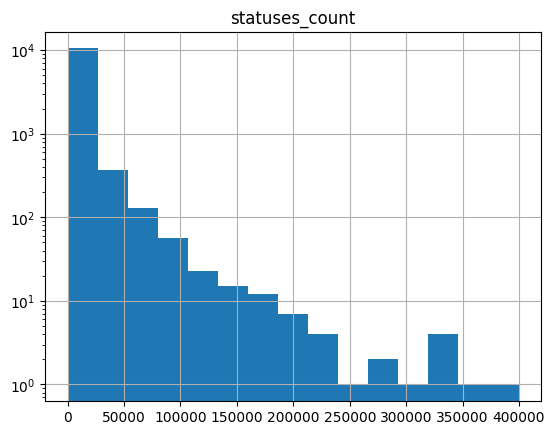

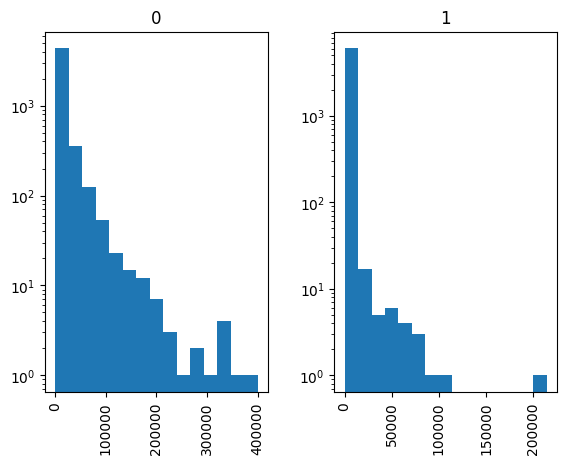

In [74]:
users_df.hist(
    column=["statuses_count"], 
    log=True, 
    bins=utils.get_sturges_bins(len(users_df["statuses_count"]))
)

users_df.hist(
    column=["statuses_count"], 
    by="bot", 
    log=True,
    bins=utils.get_sturges_bins(len(users_df["statuses_count"])) #FIX THIS: USES ALL THE SAMPLES, NOT JUST THE BOTS AND THE USERS
)

Performing outliers detection (via a boxplot) in the only numeric column we have in users dataframe: statuses_count

<AxesSubplot: >

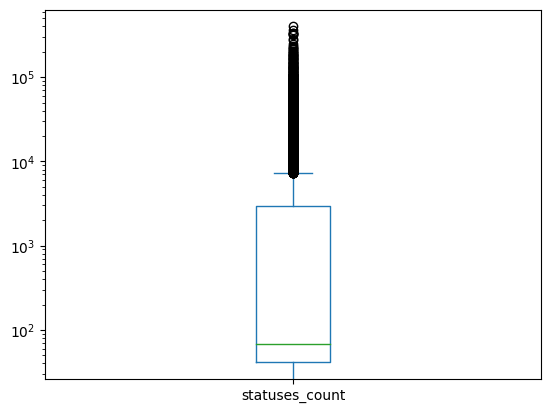

In [75]:
users_df.plot(
    kind="box",
    column="statuses_count",
    logy=True
)

By looking at the boxplot above we can see that, approximately, 10000 is the upper bound for statuses_count, so we apply this threshold.

In [76]:
#users_df.drop(users_df[users_df["statuses_count"] > 10000].index, inplace=True)

<AxesSubplot: xlabel='lang'>

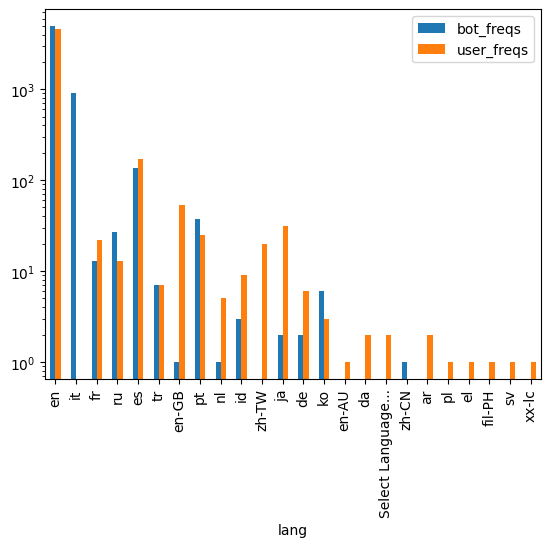

In [77]:
langs = pd.unique(users_df["lang"]) 
bot_freqs = []
user_freqs = []
for lang in langs:
    user_freqs.append(len(users_df.query(f"lang == '{lang}' & bot == 0")))
    bot_freqs.append(len(users_df.query(f"lang == '{lang}' & bot == 1")))
langs_df = pd.DataFrame({"lang": langs, "bot_freqs": bot_freqs, "user_freqs": user_freqs})
langs_df.plot.bar(x="lang", logy=True)

## Data Quality Summary

Here we should make a summary of how we believe the data quality for the users are. This could also be done after we have fixed the language issues.

## Tweets data

In tweets.csv each row contains information about a single tweet. In this case the variables
are:
1. ID: a unique identifier for the tweet
2. User Id: a unique identifier for the user who wrote the tweet
3. Retweet count: number of retweets for the tweet in analysis
4. Reply count: number of reply for the tweet in analysis
5. Favorite count: number of favorites (likes) received by the tweet
6. Num hashtags: number of hashtags used in the tweet
7. Num urls: number of urls in the tweet
8. Num mentions: number of mentions in the tweet
9. Created at: when the tweet was created
10. Text: the text of the tweet

Regarding the num * fields, we don't have to check the validity of the values and can assume they are correct, except for the null and clear incorrect values. In order to substitute the null values of "Num hashtags" field, we can exploit the information of the text (however for the mentions and urls it is impossible to check their validity because we may have a mention to a user that does not exist and we cannot know it).

### Assessing data quality

In [78]:
tweets_df.info(verbose=True, show_counts=True, memory_usage= "deep") 
# tweets_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13664696 entries, 0 to 13664695
Data columns (total 10 columns):
 #   Column          Non-Null Count     Dtype 
---  ------          --------------     ----- 
 0   id              13664694 non-null  object
 1   user_id         13447413 non-null  object
 2   retweet_count   13227562 non-null  object
 3   reply_count     13016818 non-null  object
 4   favorite_count  13017154 non-null  object
 5   num_hashtags    12607172 non-null  object
 6   num_urls        13016073 non-null  object
 7   num_mentions    12810531 non-null  object
 8   created_at      13664696 non-null  object
 9   text            13126975 non-null  object
dtypes: object(10)
memory usage: 8.9 GB


keeping only the tweets with user_id in user dataset. As these are the ones we would like to study, and have the data to verify the validity of.

In [79]:
before_dropping_rows_number = len(tweets_df.index)

numeric_ids = pd.to_numeric(tweets_df["user_id"], errors="coerce")
ids_are_not_in_users_df = numeric_ids[numeric_ids.isin(users_df["id"]) == False]
tweets_df.drop(ids_are_not_in_users_df.index, inplace=True)

tweets_df["user_id"] = pd.to_numeric(tweets_df["user_id"], errors="coerce")

after_dropping_rows_number = len(tweets_df.index)

print(f"Percentage of tweets whose author id isn't inside the users dataframe: {(100*(before_dropping_rows_number-after_dropping_rows_number))/(before_dropping_rows_number)}")

Percentage of tweets whose author id isn't inside the users dataframe: 3.56021092602426


In [58]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9364 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              9364 non-null   int64         
 1   name            9363 non-null   object        
 2   lang            9364 non-null   object        
 3   bot             9364 non-null   int64         
 4   created_at      9364 non-null   datetime64[ns]
 5   statuses_count  9364 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 512.1+ KB


clean id field by casting to int

In [22]:
tweets_df["id"] = pd.to_numeric(tweets_df["id"], errors="coerce") # cast field to int and set invalid values to NaN
# how to handle duplicates? If there are two different tweets with the same id, how to treat them?

removing tweets which are duplicates on every attribute

In [23]:
original_number_rows = len(tweets_df.index)

all_columns_duplicated_df = tweets_df[tweets_df.duplicated(subset=None, keep="first")]
all_columns_duplicated_number = len(all_columns_duplicated_df.index)

print(f"Percentage of tweets duplicated along all the columns that we are deleting(after keeping the first instance): {(100*(all_columns_duplicated_number))/original_number_rows}")

tweets_df.drop(labels=all_columns_duplicated_df.index, inplace=True)

Percentage of tweets duplicated along all the columns that we are deleting(after keeping the first instance): 14.763872577162157


In [24]:
# Not finished. It loops forever, so need to look at this some other time. - Tengel
nan_id_tweets = tweets_df["id"].isna()
#nan_id_tweets.head(1)
#print(nan_id_tweets)
print(f"{(100*(len(tweets_df[nan_id_tweets]))/(len(tweets_df)))}")
len(tweets_df[nan_id_tweets])

tweets_df.drop(labels=tweets_df[nan_id_tweets].index, inplace=True)
len(tweets_df[nan_id_tweets])
"""
p = [] # List containing the indexes of all tweets with same IDs, but with differing content where the ID fields are not NaN. Aka ID errors on the twitter dataset.
for elem in b:
    if tweets_df[tweets_df.index == elem].notna == True:
        p.append(elem)


p[:10]
len(p)
print(f"Tweets with different content on all fields except for ID which are duplicated and not of NaN value. We find {len(p)} number of these tweets. ")
print(f"This corresponds to {(100*(len(p)/len(tweets_df)))} percent of all the tweets")

"""

3.3966755345064503


198692

/tmp/ipykernel_11159/3026943906.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(tweets_df[nan_id_tweets])


0

'\np = [] # List containing the indexes of all tweets with same IDs, but with differing content where the ID fields are not NaN. Aka ID errors on the twitter dataset.\nfor elem in b:\n    if tweets_df[tweets_df.index == elem].notna == True:\n        p.append(elem)\n\n\np[:10]\nlen(p)\nprint(f"Tweets with different content on all fields except for ID which are duplicated and not of NaN value. We find {len(p)} number of these tweets. ")\nprint(f"This corresponds to {(100*(len(p)/len(tweets_df)))} percent of all the tweets")\n\n'

studying tweets which are duplicates on all attributes but the tweet id

In [25]:
tweets_equal_on_id = tweets_df[tweets_df.duplicated(subset="id", keep="first")]
tweets_equal_on_all_but_id = tweets_df[tweets_df.duplicated(
    subset=[
        "user_id", "retweet_count", "reply_count", "favorite_count", "num_hashtags", "num_urls", "num_mentions", "created_at", "text"
    ], 
    keep="first")
]

In [26]:
indexes_of_tweets_equal_on_id = [_ for _ in tweets_equal_on_id.index]
indexes_of_tweets_equal_on_all_but_id = [_ for _ in tweets_equal_on_all_but_id.index]

# List containing the indexes of all tweets equals on all columns, but have not same ID
l1 = [
    elem 
    for elem in indexes_of_tweets_equal_on_all_but_id 
    if elem not in indexes_of_tweets_equal_on_id
]
        
# List containing the indexes of all tweets with same IDs, but with differing columns.
l2 = [
    elem
    for elem in indexes_of_tweets_equal_on_id 
    if elem not in indexes_of_tweets_equal_on_all_but_id
]

print(f"Percentage of tweets with equal id, but different attributes: {(100*(len(l1)))/len(tweets_df)}")
print(f"Percentage of tweets with equal attributes, but different id: {(100*(len(l2)))/len(tweets_df)}")


Percentage of tweets with equal id, but different attributes: 0.0038223932074657003
Percentage of tweets with equal attributes, but different id: 0.0039993558559594826


In [27]:
tweets_df.drop(labels=tweets_equal_on_id.index, inplace=True)
tweets_equal_on_id = tweets_df[tweets_df.duplicated(subset="id", keep="first")]
print(f"Percentage of tweets with equal id, but different attributes: {(100*(len(tweets_equal_on_id)))/len(tweets_df)}")
tweets_equal_on_id.head()

Percentage of tweets with equal id, but different attributes: 0.0


,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text


We have decided to drop all tweets with NaN values as their ID. As it is difficult for us to ensure their validity. We have also decided to drop all tweets with duplicated IDs. Keeping only its first instance. 

As we can see from the data above. Pandas treats tweets with fields containing NaN values as different from each other. Atleast when it comes to ID. 

Lets see if we can find the tweets with real ID values.

In [80]:
columns = ["retweet_count", "reply_count", "favorite_count", "num_hashtags", "num_urls", "num_mentions"]
tweets_df[columns].describe()

,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions
count,12824089,12666033,12665999,12359131,12665215,12511186
unique,204256,137060,137084,90314,135858,113614
top,0,0,0,0,0,0
freq,9136960,11745533,9423831,10429551,9852362,7387313


The first observation that can be made is that \*_count and num_\* fields should contain only positive integers. 
The second one, by looking on the table above, is that there are some very strange values like inf or 7e+211

The following thresholds are based on the most retweet and "liked" tweets on the platform

In [29]:
thresholds = {
    "retweet_count": 3738380,
    "favorite_count": 7114892
}

print("Number of invalid values for the following columns:")
for column_name in columns:
    # casting all the columns to numeric (and setting invalid value to null)
    tweets_df[column_name] = pd.to_numeric(tweets_df[column_name], errors="coerce")

    print(f"{column_name}")
    # evaluating the presence of negative values
    negative_series = tweets_df[tweets_df[column_name] < 0][column_name]
    print(f"\tnegative: {negative_series.size}")
    tweets_df[column_name].loc[negative_series.index] = np.NaN # setting negative values to NaN
    
    # evaluating the presence of inf values
    inf_series = utils.get_inf_elements(tweets_df[column_name])
    print(f"\tinf: {inf_series.size}")
    tweets_df[column_name].loc[inf_series.index] = np.NaN # setting inf values to NaN

    # evaluating the presence of decimal values
    is_float = lambda n: (not pd.isna(n)) and (not math.isinf(n)) and (not n.is_integer())
    decimal_values_series =  tweets_df[column_name].apply(is_float)
    print(f"\tdecimals: {tweets_df[column_name][decimal_values_series].size}")
    
    # finding values above given thresholds (if specified)
    if column_name in thresholds:
        threshold = thresholds[column_name]
        above_threshold_series = tweets_df[tweets_df[column_name] > threshold ][column_name]
        print(f"\tvalues above threshold ({threshold}): {above_threshold_series[above_threshold_series > threshold].size}") 
        tweets_df[column_name].loc[above_threshold_series.index] = np.NaN # setting values above threshold to nan

Number of invalid values for the following columns:
retweet_count
	negative: 0


/tmp/ipykernel_11159/2387665683.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df[column_name].loc[negative_series.index] = np.NaN # setting negative values to NaN


	inf: 1


/tmp/ipykernel_11159/2387665683.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df[column_name].loc[inf_series.index] = np.NaN # setting inf values to NaN


	decimals: 0
	values above threshold (3738380): 19


/tmp/ipykernel_11159/2387665683.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df[column_name].loc[above_threshold_series.index] = np.NaN # setting values above threshold to nan


reply_count
	negative: 0
	inf: 1
	decimals: 0
favorite_count
	negative: 1
	inf: 0
	decimals: 0
	values above threshold (7114892): 20
num_hashtags
	negative: 0
	inf: 0
	decimals: 0
num_urls
	negative: 0
	inf: 0
	decimals: 0
num_mentions
	negative: 0
	inf: 0
	decimals: 0


created_at should be datetime

Checks if all the tweets were created after the first tweet published on twitter (so we don't have something strange like a tweet created in 01-01-1990)

In [30]:
tweets_df["created_at"] = pd.to_datetime(tweets_df["created_at"], errors="coerce")

# finding tweets created before twitter first tweet
before_time_tweets_df = tweets_df[tweets_df["created_at"] < datetime(2006,3,21,12,50,0)]
before_time_tweets_df.info()

# finding tweets created after dataset release
before_time_tweets_df = tweets_df[tweets_df["created_at"] > datetime(2022,9,29,11,0,0)]
before_time_tweets_df.info()

# what to do with these tweets? I suggest dropping/removing them.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17407 entries, 959 to 13662919
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              17407 non-null  float64       
 1   user_id         17407 non-null  int64         
 2   retweet_count   17407 non-null  float64       
 3   reply_count     17407 non-null  float64       
 4   favorite_count  17407 non-null  float64       
 5   num_hashtags    17407 non-null  float64       
 6   num_urls        17407 non-null  float64       
 7   num_mentions    17407 non-null  float64       
 8   created_at      17407 non-null  datetime64[ns]
 9   text            17332 non-null  object        
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 1.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16459 entries, 342 to 13664679
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------    

As we can see from the above values, there is 48803 tweets that were created in what we would call "pre-history" and 48802 tweets that where made in "the future". A time after the release date of this dataset. These tweets will have to be removed from the final dataset of "valid" tweets.

In [31]:
tweets_df.info(verbose=True, show_counts=True, memory_usage= "deep") 
tweets_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5650684 entries, 2 to 13664695
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   id              5650684 non-null  float64       
 1   user_id         5650684 non-null  int64         
 2   retweet_count   5435152 non-null  float64       
 3   reply_count     5387678 non-null  float64       
 4   favorite_count  5387403 non-null  float64       
 5   num_hashtags    5292391 non-null  float64       
 6   num_urls        5387361 non-null  float64       
 7   num_mentions    5339567 non-null  float64       
 8   created_at      5650684 non-null  datetime64[ns]
 9   text            5499003 non-null  object        
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 1.3 GB


,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions
count,5.650684e+06,5.650684e+06,5.435152e+06,5.387678e+06,5.387403e+06,5.292391e+06,5.387361e+06,5.339567e+06
mean,inf,1.015538e+09,4.860740e+02,3.712174e+103,6.002208e+00,1.133703e+80,7.424786e+89,1.123687e+81
std,NaN,9.176402e+08,1.520301e+04,8.616466e+106,4.300227e+03,2.608106e+83,1.723344e+93,2.596559e+84
min,9.030000e+02,8.872810e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.244566e+17,4.065108e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.914670e+17,5.391786e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.556601e+17,1.858638e+09,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,inf,3.164942e+09,3.350111e+06,2.000000e+110,7.000000e+06,6.000000e+86,4.000000e+96,6.000000e+87


#### Removing tweets with null text field, float text field or only spaces, because these are not allowed by twitter

In [32]:


tweets_df.dropna(subset=["text"], inplace=True) # drop the tweets where the text field is null
tweets_df["text"] = tweets_df["text"].astype(str) # cast the test field to string


# Problem with memory usage, we have to find a more effient way to remove tweets with only spaces
"""
to_drop = []
for index, row in tweets_df.iterrows():
    if not row["text"] or row["text"].isspace():
        tweets_df.drop(index)
"""

'\nto_drop = []\nfor index, row in tweets_df.iterrows():\n    if not row["text"] or row["text"].isspace():\n        tweets_df.drop(index)\n'

### Distribution of variables and statistics
Let's study them!

Histograms for numerical fields

"\n# REPLACING INF TO NAN; THIS IS JUST A TEMPORARY FUNCTION I PUT HERE IN ORDER TO PLOT THE HISTOGRAMS - Gianluca\nplt.rcParams['figure.figsize'] = [12, 8]\nplt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower\n####\ntweets_df.hist(\n    column=columns, \n    log=True,\n    bins=utils.get_sturges_bins(tweets_df.size)\n)\n"

array([[<AxesSubplot: title={'center': 'retweet_count'}>,
        <AxesSubplot: title={'center': 'reply_count'}>],
       [<AxesSubplot: title={'center': 'favorite_count'}>,
        <AxesSubplot: title={'center': 'num_hashtags'}>],
       [<AxesSubplot: title={'center': 'num_urls'}>,
        <AxesSubplot: title={'center': 'num_mentions'}>]], dtype=object)

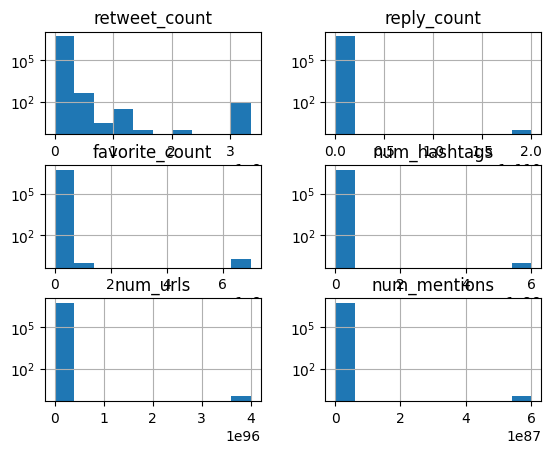

In [33]:
"""
# REPLACING INF TO NAN; THIS IS JUST A TEMPORARY FUNCTION I PUT HERE IN ORDER TO PLOT THE HISTOGRAMS - Gianluca
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
####
tweets_df.hist(
    column=columns, 
    log=True,
    bins=utils.get_sturges_bins(tweets_df.size)
)
"""
columns = ["retweet_count", "reply_count", "favorite_count", "num_hashtags", "num_urls", "num_mentions"]

tweets_df.hist(
    column=columns, 
    log=True,
    #bins=utils.get_sturges_bins(tweets_df.size)
)



Boxplots for numerical fields

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

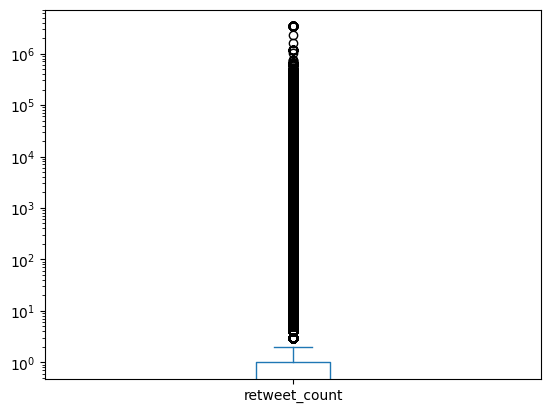

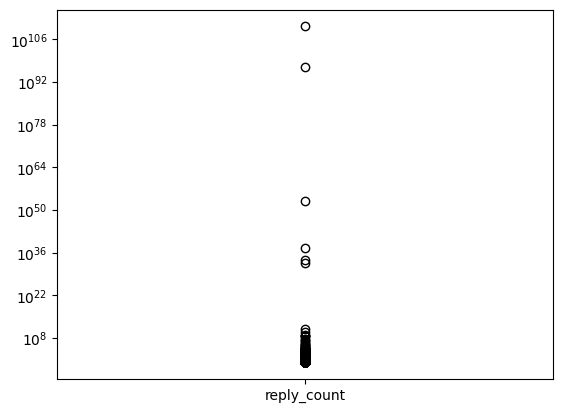

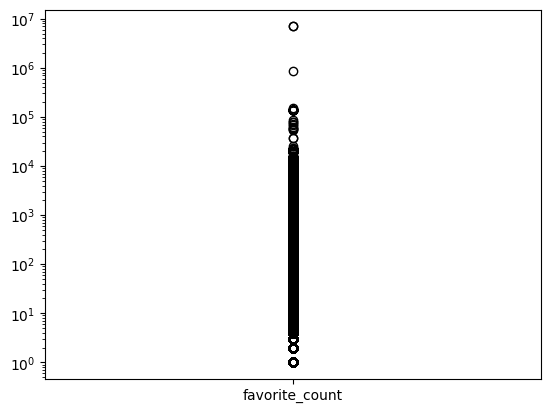

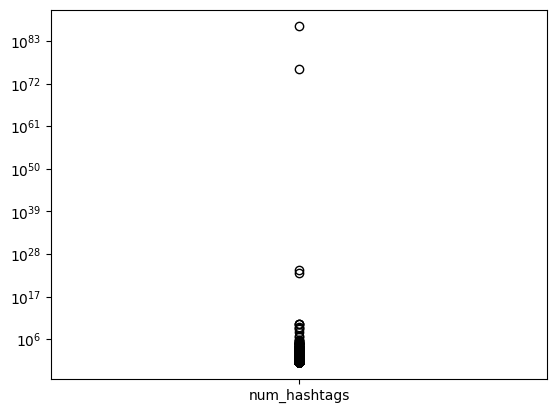

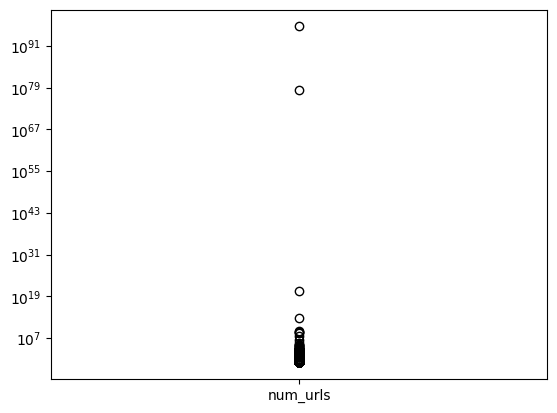

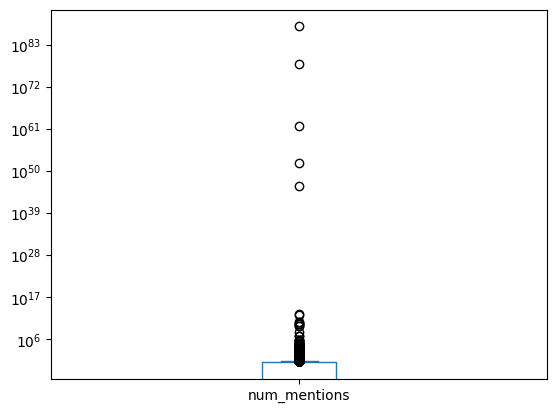

In [34]:
for column in columns:
    tweets_df.plot(kind="box",
        column=column,
        logy=True
    )

By looking at the boxplots we can see that there is a very high variance for the data (an observation supported also by the previous histograms). Hence, we compute the whiskers upper and lower bounds analitically for each column.

In [35]:
# outlier detection
outlier_thresholds = {
    column: utils.compute_whiskers(tweets_df[column])
    for column in columns
}

outlier_dataframes = {
    column: tweets_df[tweets_df[column] > outlier_thresholds[column][1]][column]
    for column in columns
}

for column in columns:
    print(f"{column}: {len(outlier_dataframes[column])} outliers")

# removal of outliers
outlier_indexes_list = [outlier_dataframe.index for outlier_dataframe in outlier_dataframes.values()]
for indexes in outlier_indexes_list:
    tweets_df.drop(indexes, inplace=True, errors="ignore")
    

retweet_count: 800152 outliers
reply_count: 15594 outliers
favorite_count: 1202548 outliers
num_hashtags: 645522 outliers
num_urls: 621971 outliers
num_mentions: 97313 outliers


In [36]:
tmp.info(verbose=True)

NameError: name 'tmp' is not defined

### Variables trasformations (?)

### Pairwise correlations

In [ ]:

merged_df = pd.merge(users_df, tweets_df, left_on=["id"], right_on=["user_id"],)

merged_df.drop(columns="user_id", inplace=True)
merged_df.rename(columns={"id_x" : "user_id"}, inplace=True)
merged_df.rename(columns={"id_y" : "tweet_id"}, inplace=True)
merged_df.rename(columns={"created_at_x" : "account_created"}, inplace=True)
merged_df.rename(columns={"created_at_y" : "tweet_created"}, inplace=True)
merged_df.head(1)

merged_df.to_csv("./dataset/merged_dataset.csv",index=False) # Removes the counting of the Index rows
#merged_df = tweets_df.join(users_df, on="id")
#merged_df.head(2)
#


#works well but problems with wrong values (like float)

,user_id,name,lang,bot,account_created,statuses_count,tweet_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,tweet_created,text
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,4.867187e+17,0.0,0.0,0.0,0.0,0.0,1.0,2019-07-11 03:49:06,"@4fri2endly0 ""A business that makes nothing bu..."
